This notebook was created for the study of a galaxy Seyfert Type II.

In [1]:
## Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad

from astropy import units as u
from astropy import constants as const

Defining our source

In [2]:
m = 2e7 # m = M / M_sun: BH mass in solar units
mdot = 0.7 # Mdot / Mdot_Edd

l = 10    # L / R_s
l_x = 5   # L_x / R_s  testar = 1 p simplificação inicial e depois vemos no espaço paramétrico
r_x = 6   # R_x / R_s

In [3]:
## Fixed Constants

Mdot_Edd = 1.45e18 * m # [g s-1] (KGS15 page 4)
R_s = 2.96e5 * m # [cm] = 2GM/c^2 (KGS15 page 4)

c = 2.9979e10 # [cm/s]
m_e = 9.1093e-28 # [g]
m_p = 1.6726e-24 # [g]
sigma_T = 6.6524e-25 # [cm2]
e = 4.8032e-10 # [statcoul]

alpha_f = 1/137 # [dim.] fine structure constant
r_0 = 2.8179e-13 # [cm] electron classical radius

In [4]:
# q = ( 1 - ( 3 * R_s / R_X)**(1/2) )**(1/4) # KGS15 page 4
q = ( 1 - ( 3 / r_x )**(1/2) )**(1/4)

va0 = c # [cm/s] Alfvén Speed (Khiali et al. 2015 page 38)

# Gamma = (1 + (v_A0 / c )**2 )**(-1/2) # KGS15 page 4
Gamma = 1 / np.sqrt(2)

In [5]:
# c = (const.c).to('cm s-1')
# m_e = (const.m_e).to('g')
# m_p = (const.m_p).to('g')
# sigma_T = (const.sigma_T).to('cm2')
# e = (const.e).value / (3.33564e-10) * u.statcoulomb

# alpha_f = 1/137 # fine structure constant [dim.]
# r_0 = 2.8179e-13 * u.cm # electron classical radius [cm]

In [6]:
def mag_rec_power(Gamma, r_X, l, l_X, q, mdot, m):
    ''' Magnetic recconection power released by turbulent fast reconnection in the surrounds of the BH.
    Eq. (15) of Kadowaki, de Gouveia Dal Pino & Singh 2015 (KGS15).'''
    # [erg s-1]
    
    return 1.66e35 * Gamma**(-1/2) * r_X**(-5/8) * l**(-1/4) * l_X * q**(-2) * mdot**(3/4) * m

def coronal_mag_field(r_x, mdot, m):
    '''Inner disk magnetic field intensity.
    Eq.(2) of KGS15.'''
    # [G]
    
    return 9.96e8 * r_x**(-5/4) * mdot**(1/2) * m**(-1/2)

def coronal_density(Gamma, r_x, l,  q, mdot, m):
    '''Eq.(7) of KGS15.'''
    # [cm-3]
    
    return 8.02e18 * Gamma**(1/2) * r_x**(-3/8) * l**(-3/4) * q**(-2) * mdot**(1/4) * m**(-1)

def coronal_temperature(Gamma, r_x, l, q, mdot):
    '''Eq.(6) of KGS15.'''
    # [K]
    
    return 2.73e9 * Gamma**(1/4) * r_x**(-3/16) * l**(1/8) * q**(-1) * mdot**(1/8)

def width_current_sheet(Gamma, r_x, l, l_x, q, mdot, m):
    '''Eq.(14) from ERRATUM of KGS15.'''
    # [cm]
    
    return 11.6 * Gamma**(-5/4) * r_x**(31/16) * l**(-5/8) * l_x * q**(-3) * mdot**(-5/8) * m

In [7]:
wdot_B = mag_rec_power(Gamma, r_x, l, l_x, q, mdot, m) # erg s-1
B_c = coronal_mag_field(r_x, mdot, m) # G
n_c = coronal_density(Gamma, r_x, l,  q, mdot, m) # cm-3
T_c = coronal_temperature(Gamma, r_x, l, q, mdot) # K
delta_RX = width_current_sheet(Gamma, r_x, l, l_x, q, mdot, m) # cm

In [8]:
print(f'\nReconnection Power:\n wdot_B = {wdot_B:.4E} erg s-1')
print(f'\nCoronal Magnetic Field:\n B_c = {B_c:.4E} G')
print(f'\nCoronal Particle Number Density:\n n_c = {n_c:.4E} cm-3')
print(f'\nCoronal Temperature:\n T_c = {T_c:.4E} K')
print(f'\nWidth of the current sheet:\n delta_RX = {delta_RX:.4E} cm')


Reconnection Power:
 wdot_B = 5.1226E+42 erg s-1

Coronal Magnetic Field:
 B_c = 1.9843E+04 G

Coronal Particle Number Density:
 n_c = 5.1761E+10 cm-3

Coronal Temperature:
 T_c = 3.1016E+09 K

Width of the current sheet:
 delta_RX = 4.2860E+10 cm


In [9]:
erg = 1.602177e-12 # [1 eV = 1.6022e-12 erg]

Ee = np.linspace(1e9, 1e15)*erg # Energy range [erg]

rho = B_c * B_c / (va0*va0 * 4*np.pi) # fluid density [cm-3]

In [10]:
## Hadronic Acceleration by Reconnection and Shock

def tacc_p_rec(E, lacc, B, rho):
    '''Eq. (6) of Khiali et al. (2015)'''
    va0 = B / np.sqrt(4 * np.pi * rho)
    Gamma = 1 / np.sqrt(2)
    va = va0 * Gamma # [cm s-1] Alfvén velocity
    t0 = lacc / va # [s] Alfvén time
    E0 = m_p*c*c # [erg]

    return 1.5 * (E/E0)**(-0.1) * t0**(-1)
    

def tacc_shock(B, E):
    '''Eq.(9) of Khiali et al. 2015 / Eq. (10) of Romero et al. (2010a)'''
    eta = 0.1 # Efficiency of the acceleration [adim]

    return (eta*e*c*B) / E


def t_pp(n, E):
    '''Eq. (19) of Khiali et al. (2015)'''
    L = np.log(E/ (1*1e12*erg) ) # 1 TeV = 1 * 1e12 * erg per eV
    E_th = 280 *1e6*erg # [erg] 1 MeV = 1 * 1e6 * erg per eV - Proton threshold kinetic energy for neutral pion production
    sigma_pp = (34.3 + 1.88*L + 0.25*L**2) * (1 - (E_th/E)**4 )**2 # [mb] millibarn
    k_pp = 0.5 # Total inelasticity of the process
    
    return n*c*sigma_pp*k_pp


## Photomeson

def sigma_pgamma(epsilon_r):
    """Simplified approach to calculate the cross-section.
    Eq.(41) of Khiali et al. 2015."""
    if 300e6 * erg <= epsilon_r <= 500e6 * erg:
        return 340e-30  # 340 microbarn in cm^2 if 300 MeV <= eps <= 500 MeV
    elif epsilon_r > 500e6 * erg:
        return 120e-30  # 120 microbarn in cm^2 if eps > 500 MeV
    else:
        return 0
    
def K_pgamma(epsilon_r):
    """Simplified approach to calculate the inelasticity of the interaction.
    Eq.(42) of Khiali et al. 2015."""
    if 300e6 * erg <= epsilon_r <= 500e6 * erg:
        return 0.2  # 0.2 if 300 MeV <= eps <= 500 MeV
    elif epsilon_r > 500e6 * erg:
        return 0.6  # 0.6 if eps > 500 MeV
    else:
        return 0
    
def n_ph(E_ph):
    """Isotropic photon field density.
    Eq. (4) from Mbarek et al. 2023."""
    r_c = 10 * R_s  # coronal size
    L_x = 5 * R_s
    epsilon_0 = 7e3 * erg # [erg] 7 keV = 7e3 * erg to eV compton hump energy
    
    U_x = L_x / (4 * np.pi * c * r_c**2)

    E_ph_min = 2 * erg # [erg] = 2 keV
    E_ph_max = 200.0 * erg # [erg] = 200 keV

    def dn_depsilon(epsilon):
        if epsilon < 20.0 * erg:
            return U_x * epsilon_0**(-2)
        elif 20.0 * erg <= epsilon <= 200.0 * erg:
            return U_x * epsilon**(-2)
        else:
            return 0.0

    ## Integrate dn/depsilon * epsilon over the energy ranges
    n_E_ph, _ = quad(lambda epsilon: dn_depsilon(epsilon) * epsilon, E_ph_min, E_ph_max)
    
    return n_E_ph
    

def t_pgamma(n, E):
    '''Eq.(40) of Khiali et al. 2015'''
    E_th = 145 * 1e6 * erg # [erg] 1 MeV = 1 * 1e6 * erg per eV - Photomeson production threshold for photon energies
    gamma_p = E / (m_e*c*c)
    
    lower_Eph = E_th / (2 * gamma_p)
    
    def integrand_Eph(E_ph):
        
        def integrand_epsr(epsilon_r):
            return sigma_pgamma(epsilon_r) * K_pgamma(epsilon_r) * epsilon_r
        
        # epsilon_r: photon energy in the rest frame of the proton
        lower_epsr = E_th
        upper_epsr = 2 * E_ph * gamma_p
        
        epsilon_r = np.linspace(20 * 1e3 * erg, 500 * 1e6 * erg, 100000)  # 20 keV a 500 MeV
        integral_epsr = np.trapz(integrand_epsr(epsilon_r), epsilon_r)
        
        return (n_ph(E_ph) / E_ph**2) * integral_epsr
    
    integral_Eph, _ = quad(lambda E_ph: integrand_Eph(E_ph), lower_Eph, 1e12)
    
    return c / (2 * gamma_p**2) * integral_Eph

In [11]:
## Leptonic Acceleration by Reconnection and Shock

def tacc_e_rec(E, lacc, B, rho):
    '''Eq. (7) of Khiali et al. (2015)'''
    va0 = B / np.sqrt(4 * np.pi * rho)
    Gamma = 1 / np.sqrt(2)
    va = va0 * Gamma # [cm s-1] Alfvén velocity
    t0 = lacc / va # [s] Alfvén time
    E0 = m_p*c*c # [erg]

    return 1.5 * np.sqrt(m_p/m_e) * ((E/E0)**(-0.1)) * t0**(-1)


## Leptonic Radiative Losses

def tloss_syn(B, E, m):
    '''Eq. (12) of Romero et al. (2010a)'''
    
    return (4/3)*((m_e/m)**3)*sigma_T*c*B*B / (m_e*c*c*8*np.pi) * (E/(m*c*c))

def tloss_bre(n, Z, E):
    '''Eq. (17) of Romero et al. (2010a)'''
    
    return 4*n*Z*Z*r_0*r_0*alpha_f*c*(np.log(2*E / (m_e*c*c)) - 1/3)


Hadrons

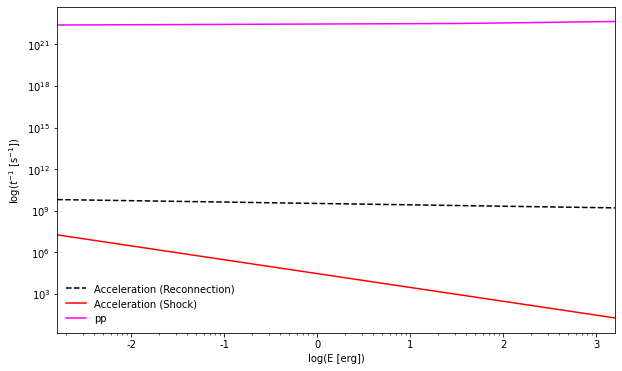

In [12]:
## erg

plt.figure(figsize=(10, 6))
plt.loglog(Ee,tacc_p_rec(Ee, l_x, B_c, rho),'--',label='Acceleration (Reconnection)',color='k')
plt.loglog(Ee,tacc_shock(B_c, Ee),label='Acceleration (Shock)',color='r')
plt.loglog(Ee,t_pp(n_c, Ee),label='pp',color='magenta')
# plt.loglog(Ee,t_pgamma(n_c, Ee),label='p-gamma',color='cyan')

plt.xlim((Ee.min(),Ee.max()))
plt.legend(frameon=False)
plt.xlabel('log(E [erg])')
plt.ylabel('log($t^{-1}$ [s$^{-1}$])')
# plt.ylim((1e-4,1e4))
plt.xticks([1e-2,1e-1,1e0,1e1,1e2,1e3],labels=['-2','-1','0','1','2','3'])
plt.savefig('plots/cooling_hadrons_erg.png',dpi=300)

plt.show()

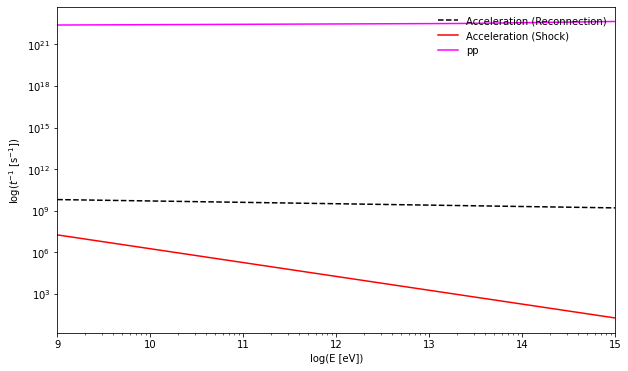

In [13]:
## eV

plt.figure(figsize=(10, 6))

plt.loglog(Ee/erg,tacc_p_rec(Ee, l_x, B_c, rho),'--',label='Acceleration (Reconnection)',color='k')
plt.loglog(Ee/erg,tacc_shock(B_c, Ee),label='Acceleration (Shock)',color='r')
plt.loglog(Ee/erg,t_pp(n_c, Ee),label='pp',color='magenta')
# plt.loglog(Ee/erg,t_pgamma(n_c, Ee),label='p-gamma',color='cyan')

plt.xlim((Ee.min()/erg,Ee.max()/erg))
plt.legend(frameon=False,loc='upper right')
plt.xlabel('log(E [eV])')
plt.ylabel('log($t^{-1}$ [s$^{-1}$])')
# plt.ylim((1e-11,1e9))
plt.xticks([1e9,1e10,1e11,1e12,1e13,1e14,1e15],labels=['9','10','11','12','13','14','15'])

plt.savefig('plots/cooling_hadrons_eV.png',dpi=300)

plt.show()

Leptons

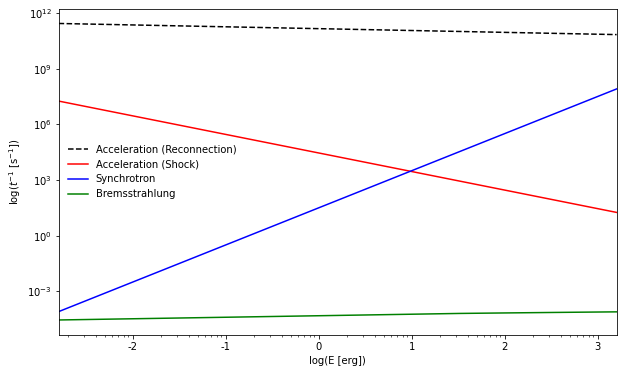

In [14]:
## erg

plt.figure(figsize=(10, 6))
plt.loglog(Ee,tacc_e_rec(Ee, l_x, B_c, rho),'--',label='Acceleration (Reconnection)',color='k')
plt.loglog(Ee,tacc_shock(B_c, Ee),label='Acceleration (Shock)',color='r')
plt.loglog(Ee,tloss_syn(Ee, B_c, m_e),label='Synchrotron',color='blue')
plt.loglog(Ee,tloss_bre(n_c, 1, Ee),label='Bremsstrahlung',color='green')

plt.xlim((Ee.min(),Ee.max()))
plt.legend(frameon=False)
plt.xlabel('log(E [erg])')
plt.ylabel('log($t^{-1}$ [s$^{-1}$])')
# plt.ylim((1e-4,1e4))
plt.xticks([1e-2,1e-1,1e0,1e1,1e2,1e3],labels=['-2','-1','0','1','2','3'])
plt.savefig('plots/cooling_leptons_erg.png',dpi=300)

plt.show()

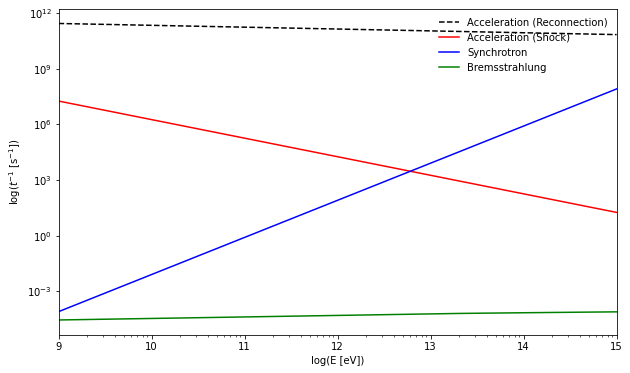

In [15]:
## eV

plt.figure(figsize=(10, 6))

plt.loglog(Ee/erg,tacc_e_rec(Ee, l_x, B_c, rho),'--',label='Acceleration (Reconnection)',color='k')
plt.loglog(Ee/erg,tacc_shock(B_c, Ee),label='Acceleration (Shock)',color='r')
plt.loglog(Ee/erg,tloss_syn(Ee, B_c, m_e),label='Synchrotron',color='blue')
plt.loglog(Ee/erg,tloss_bre(n_c, 1, Ee),label='Bremsstrahlung',color='green')

plt.xlim((Ee.min()/erg,Ee.max()/erg))
plt.legend(frameon=False,loc='upper right')
plt.xlabel('log(E [eV])')
plt.ylabel('log($t^{-1}$ [s$^{-1}$])')
# plt.ylim((1e-11,1e9))
plt.xticks([1e9,1e10,1e11,1e12,1e13,1e14,1e15],labels=['9','10','11','12','13','14','15'])

plt.savefig('plots/cooling_leptons_eV.png',dpi=300)

plt.show()